# Sampling from the Bingham distribution

Please note that this notebook assumes that the pre-computed samples are saved in the results directory. If you would like to run the samplers, see the file `bingham.py`

In this test, we aim to sample from the Bingham distribution (Mardia and Jupp, 2000) whose unnormalized density is defined as

$$
\begin{equation}
	p_{\text{Bing}}{}(x) = \exp(-x^T\!Ax)
\tag{1}
\end{equation}
$$

for $x\in\mathbb S^{d-1}$. Without loss of generality, the matrix $A \in \mathbb R^{d\times d}$ is symmetric such that we can transform the variables into the eigenbasis of $A$. In the following, we assume that the variables underwent this transformation by letting $A = \text{diag}(\kappa_1, \ldots, \kappa_{d})$ where $\kappa_1 \le \kappa_2 \le \ldots \le \kappa_d$ are the eigenvalues of $A$. Because the Bingham distribution is invariant under shifts of the diagonal of $A$, i.e., invariant under $A\mapsto A + c\, \mathrm{Id}_d$, where $c\in\mathbb R$ is some constant, we can let $\kappa_1 = 0$. The Bingham distribution is bimodal with symmetric modes at $\pm u_{d}$ where $u_{d} \in \mathbb S^{d-1}$ is the eigenvector of $A$ with the largest eigenvalue $\kappa_{d}$. The maximal value of the logarithm of the unnormalized probability density is $\kappa_d$, i.e., $\max_{x\in\mathbb S^{d-1}} \log p_{\text{Bing}}(x) = \kappa_{d}$.Various algorithms for simulating the Bingham distribution have been proposed. The algorithm by Kent et al. (2018) is particularly attractive because it uses an acceptance/rejection sampler based on the angular central Gaussian (ACG) distribution as an envelope and is therefore straightforward to implement. We use this method as a baseline against which we compare our slice samplers as well as RWMH and HMC. We run the geodesic slice samplers on the sphere (geoSSS) as well as RWMH and HMC on two high-dimensional Bingham targets with $d=10$ and $d=50$, respectively. For each target and sampling algorithm, we simulate the consecutive Markov chain realizations $x_1,\dots,x_{N}$ with $N=10^5$ starting from the mode $u_{d}$. To explore the variability of all MCMC algorithms, we run 10 repetitions. The step-size parameter of the RWMH and HMC algorithm is automatically tuned to achieve a reasonable average acceptance rate.

In [ ]:
import os
import geosss as gs
from geosss.io import load

n_samples = int(1e5)  # number of samples
burnin = int(0.1 * n_samples)  # burn-in
n_runs = 10  # no. of runs (ESS for `n_runs=10`)

# dimension and lambda, ind 0 or 1 for plots with
# 10 and 50 dimensions respectively
ind = 0
d, vmax = [(10, 30.0), (50, 300.0)][ind]

# save directory (generate results/ dir if non-existent)
filename = f"bingham_d{d}_vmax{int(vmax)}"
loaddir = f"results/{filename}"
os.makedirs(loaddir, exist_ok=True)

# bingham distribution as pdf which is fixed
pdf = gs.random_bingham(d=d, vmax=vmax, vmin=0.0, eigensystem=True, seed=6982)

# sampler methods
initial = pdf.mode
methods = ("sss-reject", "sss-shrink", "rwmh", "hmc")
algos = {
    "sss-reject": "geoSSS (reject)",
    "sss-shrink": "geoSSS (shrink)",
    "rwmh": "RWMH",
    "hmc": "HMC",
}

try:
    runs_samples = load(f"{loaddir}/bingham_d{d}_vmax{int(vmax)}.pkl")
    print(f"Loading file {loaddir}/bingham_d{d}_vmax{int(vmax)}.pkl")
except FileNotFoundError:
    raise

# Loading the first run `ind=0` to generate plots in paper
ind = 0
samples = runs_samples if isinstance(runs_samples, dict) else runs_samples[ind]

Loading file results/bingham_d10_vmax30/bingham_d10_vmax30.pkl


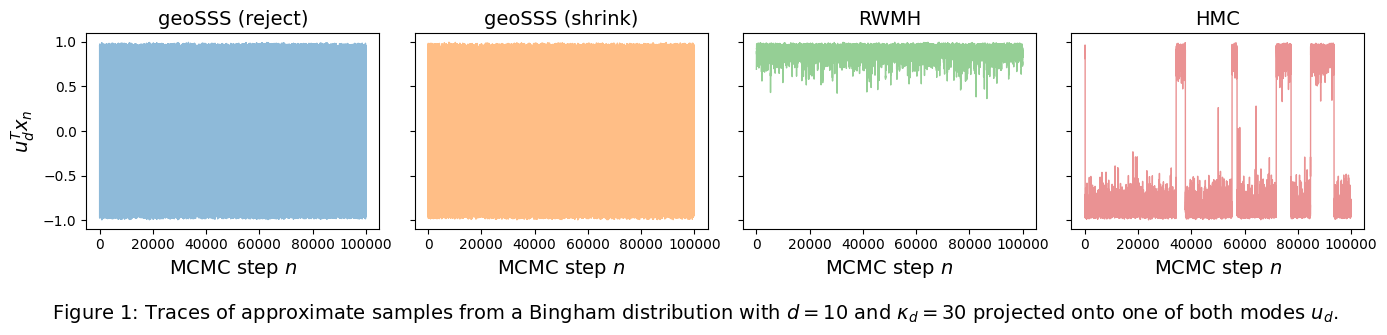

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharex=True, sharey=True)
fs = 14
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for ax, method, color in zip(axes, methods, colors):
    ax.set_title(algos[method], fontsize=fs)
    ax.plot(samples[method] @ pdf.mode, alpha=0.5, color=color, lw=1)
    ax.set_xlabel(r"MCMC step $n$", fontsize=fs)
axes[0].set_ylabel(r"$u_{d}^Tx_n$", fontsize=fs)
fig.text(
    0.5,
    -0.1,
    r"Figure 1: Traces of approximate samples from a Bingham distribution with $d=10$ and $\kappa_d = 30$ projected onto one of both modes $u_d$.",
    ha="center",
    va="bottom",
    fontsize=fs,
    wrap=True,
)
fig.tight_layout()

The first Bingham target has $d=10$ and $\kappa_{d} = 30$. In Figure 1, we show traces of approximate Bingham samples projected onto the first mode, that is $u_{d}^T x$, which varies between $1$ and $-1$ and is expected to peak somewhat below these extreme values that correspond to both modes. As is evident from the trace plots, both variants of geodesic slice sampling on the sphere find both modes of the Bingham distribution and rapidly jump between them. RWMH, on the other hand, does not escape from the mode in which the chain was started and therefore only finds a single mode. HMC also finds the second mode, but only jumps occasionally between the two modes.

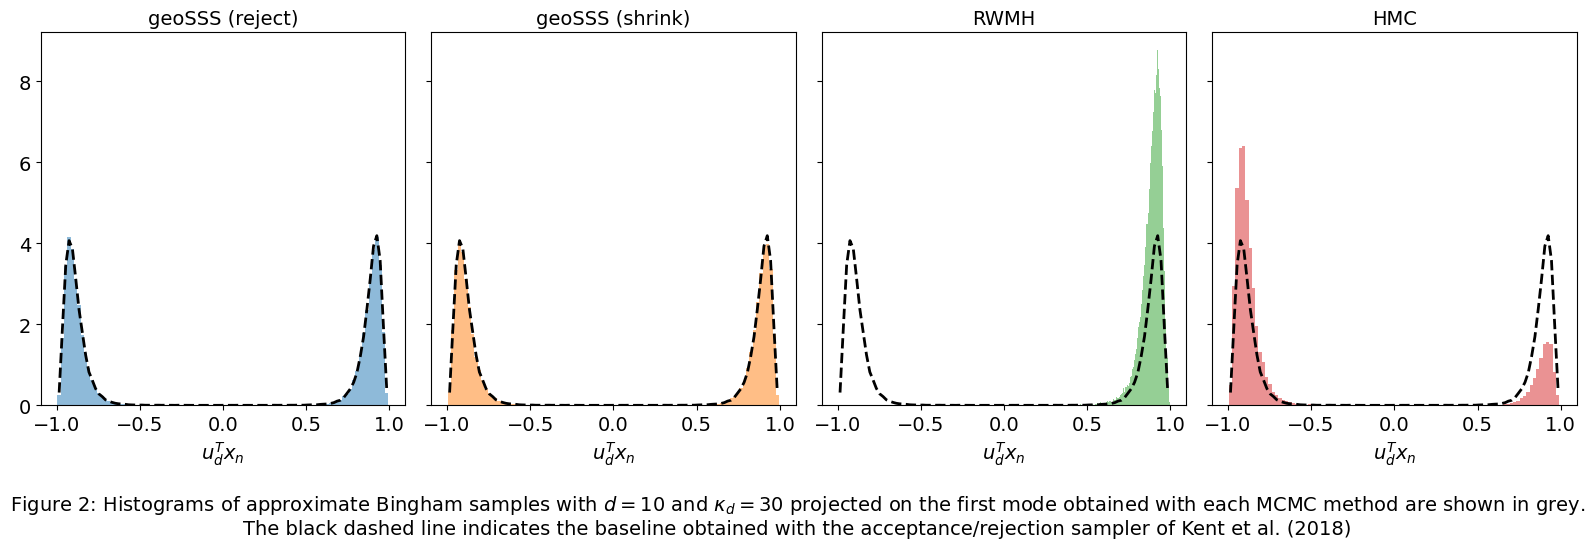

In [3]:
import numpy as np

vals = samples["kent"] @ pdf.mode
ref = list(np.histogram(vals, bins=100, density=True))
ref[1] = 0.5 * (ref[1][1:] + ref[1][:-1])
plt.rc("font", size=fs)
fig, axes = plt.subplots(
    1, len(methods), figsize=(len(methods) * 4, 5), sharex=True, sharey=True
)
for ax, method, color in zip(axes, methods, colors):
    ax.set_title(algos[method], fontsize=fs)
    bins = ax.hist(
        samples[method] @ pdf.mode,
        bins=100,
        density=True,
        alpha=0.5,
        color=color,
        histtype="stepfilled",
    )[1]
    ax.plot(*ref[::-1], color="k", lw=2, ls="--")
    ax.set_xlabel(r"$u_{d}^Tx_n$", fontsize=fs)
fig.text(
    0.5,
    -0.1,
    r"Figure 2: Histograms of approximate Bingham samples with $d=10$ and $\kappa_d = 30$ projected on the first mode obtained with each MCMC method are shown in grey."
    "\nThe black dashed line indicates the baseline obtained with the acceptance/rejection sampler of Kent et al. (2018)",
    ha="center",
    va="bottom",
    fontsize=fs,
    wrap=True,
)
fig.tight_layout()

The insufficient sampling by RWMH and HMC results in an incorrect exploration of the modes, which should be populated equally. This is illustrated in Fig. 2 which also shows the distribution of $u_{d}^Tx$ obtained by the aforementioned acceptance/rejection method of Kent et al. (2018). The histograms obtained with the geodesic slice samplers closely match the baseline, whereas RWMH completely misses the second mode and HMC misrepresents the probability mass under the modes.

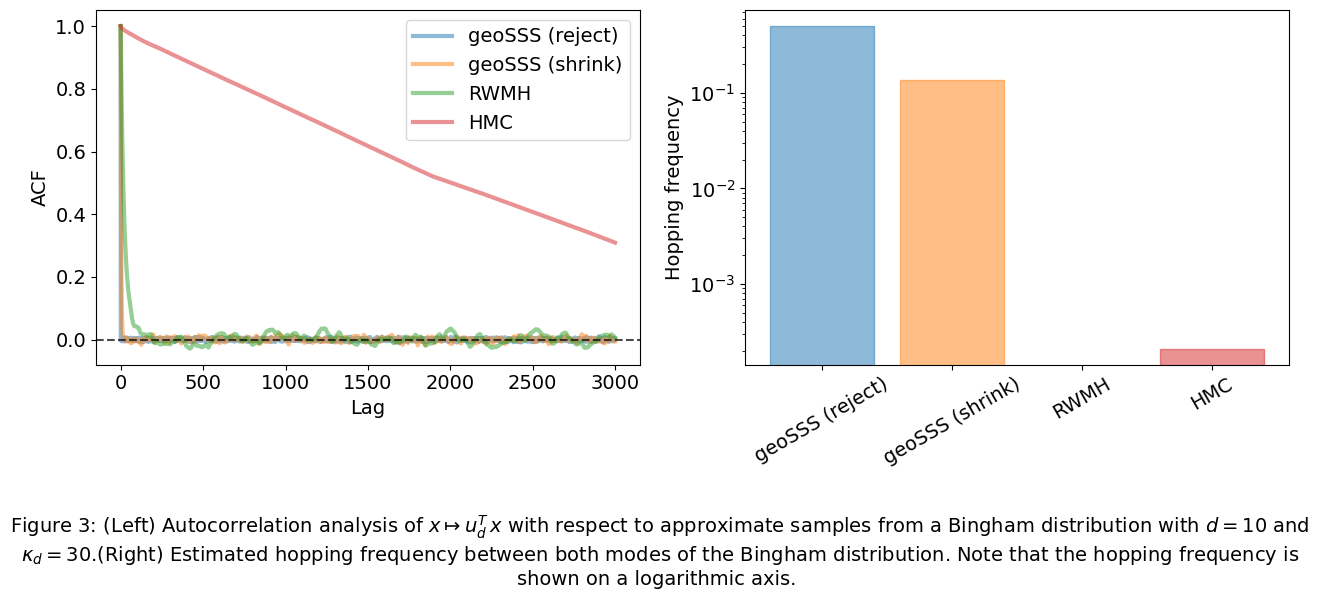

In [4]:
def hopping_frequency(samples, pdf):
    """hopping frequency between the two modes of bingham"""
    return np.mean(np.diff(np.sign(samples @ pdf.mode)) != 0.0)


fig, axes = plt.subplots(1, 2, figsize=(13, 5))
ax = axes[0]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for method in methods:
    ac = gs.acf(samples[method] @ pdf.mode, 3000)
    ax.plot(ac, alpha=0.5, lw=3, label=algos[method])
ax.legend(fontsize=fs, loc="upper right")
ax.axhline(0.0, ls="--", color="k", alpha=0.7)
ax.set_xlabel(r"Lag", fontsize=fs)
ax.set_ylabel("ACF", fontsize=fs)
# hopping frequency as bar plot
freqs = [hopping_frequency(samples[method], pdf) for method in methods]
ax = axes[1]
ax.set_ylabel("Hopping frequency")
ax.bar(list(map(algos.get, methods)), freqs, color=colors, alpha=0.5, edgecolor=colors)
# ax.set_ylim(None, 1.0)
ax.semilogy()
plt.xticks(rotation=30)
fig.text(
    0.5,
    -0.2,
    r"Figure 3: (Left) Autocorrelation analysis of $x\mapsto u_d^T\,x$ with respect to approximate samples from a Bingham distribution with $d=10$ and $\kappa_d = 30$."
    "(Right) Estimated hopping frequency between both modes of the Bingham distribution. Note that the hopping frequency is shown on a logarithmic axis. ",
    ha="center",
    va="bottom",
    fontsize=fs,
    wrap=True,
)
fig.tight_layout()

Figure 3 shows the autocorrelation function (ACF) of $u_{d}^T x$ for the four MCMC samplers. We see a rapid decorrelation in case of both geodesic slice samplers; in fact, the ACF of rejection-based geoSSS drops to zero after a single step. Samples generated with RWMH decorrelate after roughly $200$ MCMC steps, but the faster decorrelation (in comparison to HMC) is due to the fact that RWMH only explores a single mode. HMC finds both modes but shows a very slowly decaying ACF, because jumps between the two modes only occur very rarely. This is also reflected in the effective sample size (ESS). Due to the immediate decorrelation of samples generated with geoSSS using a rejection strategy, the *relative ESS* which is ESS divided by the total number of performed MCMC steps, (in our experiments $10^5$) is estimated to be $99.73\,\%$. The shrinkage-based geoSSS obtains a relative ESS of $15.2\,\%$, whereas RMWH and HMC achieve only very low relative ESS: $0.004\,\%$ and $0.01\,\%$, respectively.

To quantify how rapidly the MCMC samplers mix between the two modes of the Bingham distribution, we estimated a *hopping frequency*, which we define as the average number of times the Markov chain jumps from one mode to the other, given by
$$
\begin{equation}\
	\frac{1}{N-1} \sum_{n=1}^{N-1} [[ \text{sign}(u_d^Tx_{n+1}) \not= \text{sign}(u_d^Tx_{n}) ]],
\tag{2}
\end{equation}
$$
where $x_n$ is the realization of the $n$-th Markov chain sample, $N$ the total number of steps and $[[ \cdot ]]$ denotes the Iverson bracket. For proposition $S$ it holds that $[[ S ]] = 1$ if $S$ is a true and $[[ S ]] = 0$ otherwise. Figure 3 (right panel) shows the estimated hopping frequencies. As expected, the rejection-based  geoSSS shows the highest number of oscillations between both modes with approximately $50\%$ hopping frequency, whereas the shrinkage-based geoSSS tends to jump only every seventh step to the other mode. This behavior is expected, because the geodesic level set always contains both modes with equal probability. Therefore, the rejection sampling strategy finds each mode with equal probability, independent of what the current state of the Markov chain is. The shrinkage-based approach has a higher chance to stay in the vicinity of the current state.

average great circle distance of successive samples: 1.58 (sss-reject)
average great circle distance of successive samples: 0.54 (sss-shrink)
average great circle distance of successive samples: 0.10 (rwmh)
average great circle distance of successive samples: 0.22 (hmc)


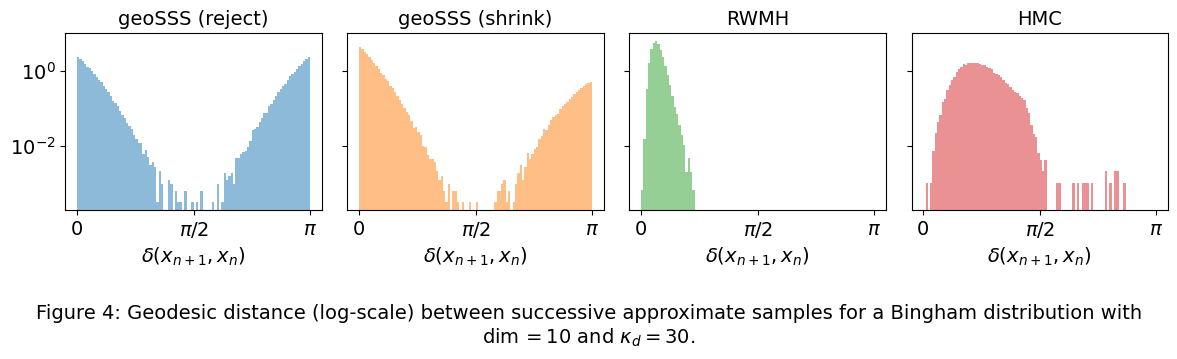

In [5]:
fig, axes = plt.subplots(
    1, len(methods), figsize=(len(methods) * 3, 3), sharex=True, sharey=True
)
bins = 100
for ax, method in zip(axes, methods):
    ax.set_title(algos[method], fontsize=fs)
    # distance between successive samples
    x = samples[method]
    dist = gs.distance(x[:-1], x[1:])
    print(
        "average great circle distance of successive samples: "
        f"{np.mean(dist):.2f} ({method})"
    )
    bins = ax.hist(
        dist,
        bins=bins,
        density=True,
        alpha=0.5,
        color=colors[methods.index(method)],
        histtype="stepfilled",
    )[1]
    ax.set_xlabel(r"$\delta(x_{n+1}, x_n)$", fontsize=fs)
    ax.set_xticks(np.linspace(0.0, np.pi, 3))
    ax.set_xticklabels(["0", r"$\pi/2$", r"$\pi$"])
    ax.set_yscale("log")
fig.text(
    0.5,
    -0.2,
    r"Figure 4: Geodesic distance (log-scale) between successive approximate samples for a Bingham distribution with $\dim=10$ and $\kappa_d=30$.",
    ha="center",
    va="bottom",
    fontsize=fs,
    wrap=True,
)
fig.tight_layout()

Another quality measure is the geodesic or great circle distance between successive samples given as
$$
\delta(x_{n+1}, x_n) := \arccos(x_{n+1}^T x_n)\, .
$$
An efficient MCMC algorithm should explore the sphere rapidly by making large leaps from one sample to the next. Again, we see in Fig. 4 a superior performance of geoSSS. The RWMH algorithm achieves only small jumps. As expected, HMC moves more rapidly over the sphere compared to RWMH, but it still cannot compete with the geodesic slice samplers. 

## Bingham distribution for $d=50$ and $\kappa_d=300$

We also run similar tests on a more challenging Bingham target with $d=50$ and $\kappa_{d} = 300$, i.e., the dimension of the sample space is much larger and the distribution is more concentrated. We observe the same trends as before. Figure 5 shows the distribution of samples projected onto the first mode. Now, both RWMH and HMC are stuck in the first mode and fail to find the second mode, whereas the geodesic slice samplers represent both modes accurately. The ACF of HMC outperforms RWMH as expected (see left panel of Fig. 6), but still the geodesic slice samplers show a faster decorrelation than HMC resulting in a higher effective sample size. Since no jumps occur during the entire run of RWMH and HMC, their hopping frequencies are estimated to be smaller than $10^{-5}$, whereas geoSSS still achieves an acceptable jump rate (see right panel of Fig. 6). The rejection-based geoSSS clearly outperforms the shrinkage strategy on this target by achieving a higher hopping rate and as a consequence also a more favorable distribution of step sizes $\delta(x_{n+1}, x_{n})$ (see Fig. 7).

In [6]:
n_samples = int(1e5)  # number of samples
burnin = int(0.1 * n_samples)  # burn-in
n_runs = 10  # no. of runs (ESS for `n_runs=10`)

# dimension and lambda, ind 0 or 1 for plots with
# 10 and 50 dimensions respectively
ind = 1
d, vmax = [(10, 30.0), (50, 300.0)][ind]

# save directory (generate results/ dir if non-existent)
filename = f"bingham_d{d}_vmax{int(vmax)}"
loaddir = f"results/{filename}"
os.makedirs(loaddir, exist_ok=True)

# bingham distribution as pdf which is fixed
pdf = gs.random_bingham(d=d, vmax=vmax, vmin=0.0, eigensystem=True, seed=6982)

# sampler methods
initial = pdf.mode
methods = ("sss-reject", "sss-shrink", "rwmh", "hmc")
algos = {
    "sss-reject": "geoSSS (reject)",
    "sss-shrink": "geoSSS (shrink)",
    "rwmh": "RWMH",
    "hmc": "HMC",
}

try:
    runs_samples = load(f"{loaddir}/bingham_d{d}_vmax{int(vmax)}.pkl")
    print(f"Loading file {loaddir}/bingham_d{d}_vmax{int(vmax)}.pkl")
except FileNotFoundError:
    raise

# Loading the first run `ind=0` to generate plots in paper
ind = 0
samples_d50 = runs_samples if isinstance(runs_samples, dict) else runs_samples[ind]

Loading file results/bingham_d50_vmax300/bingham_d50_vmax300.pkl


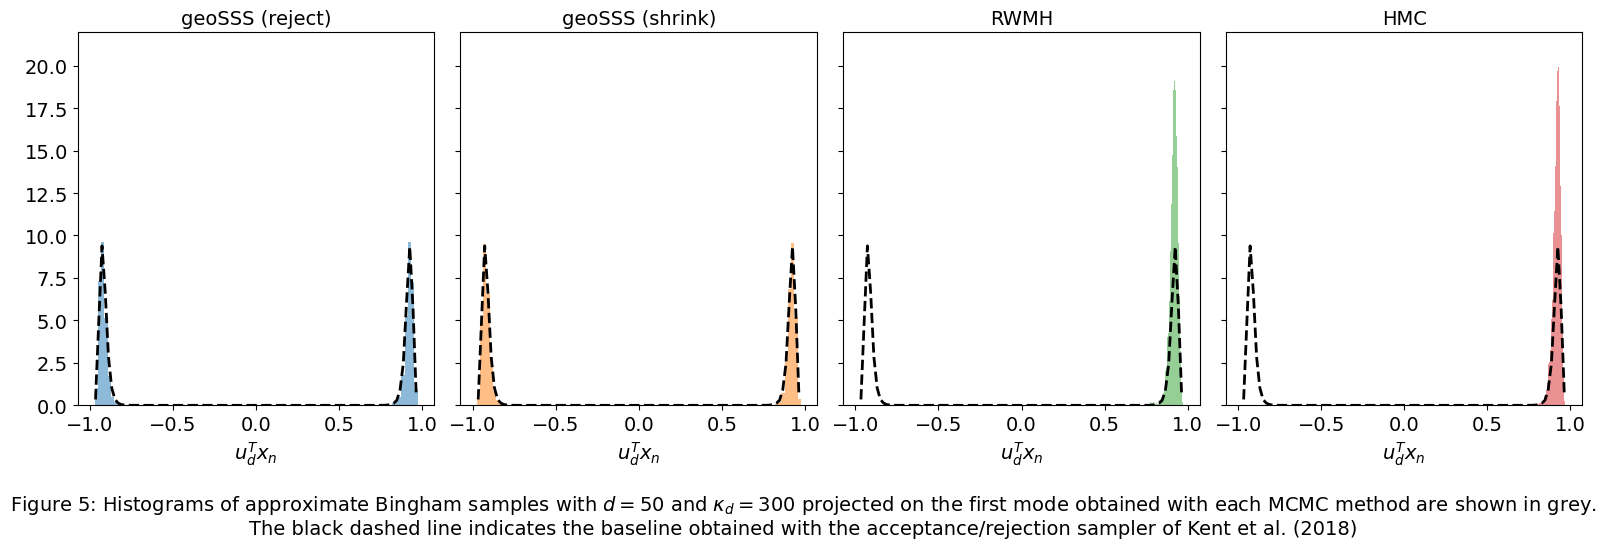

In [7]:
vals = samples_d50["kent"] @ pdf.mode
ref = list(np.histogram(vals, bins=100, density=True))
ref[1] = 0.5 * (ref[1][1:] + ref[1][:-1])
plt.rc("font", size=fs)
fig, axes = plt.subplots(
    1, len(methods), figsize=(len(methods) * 4, 5), sharex=True, sharey=True
)
for ax, method, color in zip(axes, methods, colors):
    ax.set_title(algos[method], fontsize=fs)
    bins = ax.hist(
        samples_d50[method] @ pdf.mode,
        bins=100,
        density=True,
        alpha=0.5,
        color=color,
        histtype="stepfilled",
    )[1]
    ax.plot(*ref[::-1], color="k", lw=2, ls="--")
    ax.set_xlabel(r"$u_{d}^Tx_n$", fontsize=fs)
fig.text(
    0.5,
    -0.1,
    r"Figure 5: Histograms of approximate Bingham samples with $d=50$ and $\kappa_d = 300$ projected on the first mode obtained with each MCMC method are shown in grey."
    "\nThe black dashed line indicates the baseline obtained with the acceptance/rejection sampler of Kent et al. (2018)",
    ha="center",
    va="bottom",
    fontsize=fs,
    wrap=True,
)
fig.tight_layout()


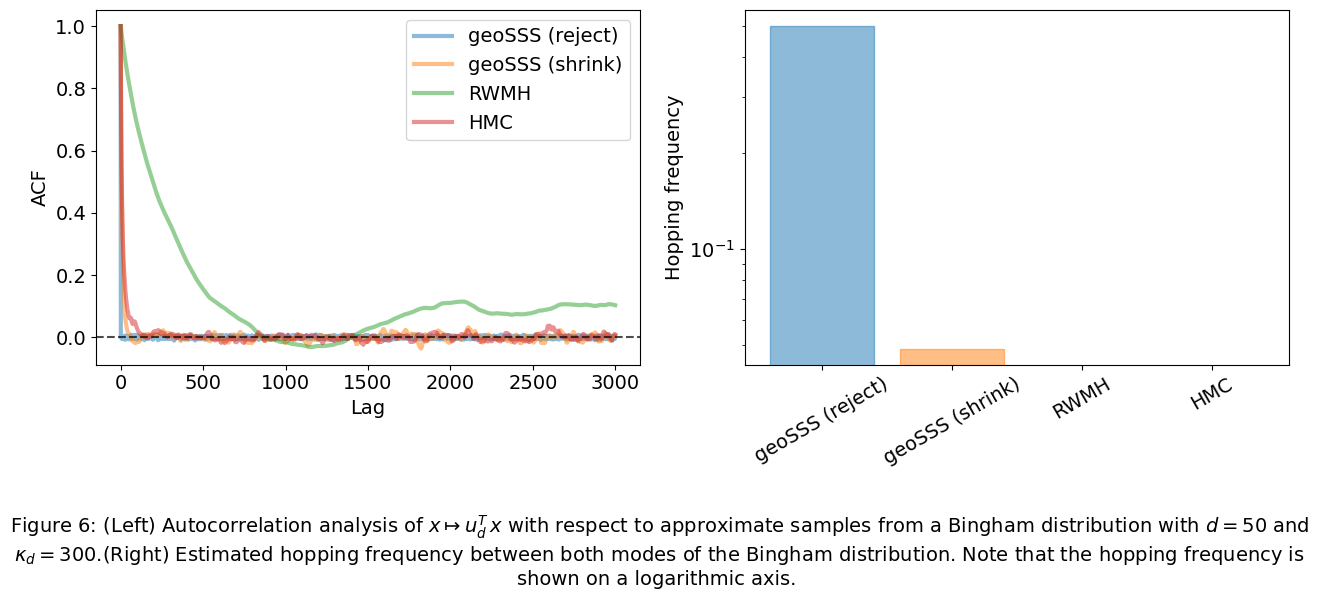

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
ax = axes[0]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for method in methods:
    ac = gs.acf(samples_d50[method] @ pdf.mode, 3000)
    ax.plot(ac, alpha=0.5, lw=3, label=algos[method])
ax.legend(fontsize=fs, loc="upper right")
ax.axhline(0.0, ls="--", color="k", alpha=0.7)
ax.set_xlabel(r"Lag", fontsize=fs)
ax.set_ylabel("ACF", fontsize=fs)
# hopping frequency as bar plot
freqs = [hopping_frequency(samples_d50[method], pdf) for method in methods]
ax = axes[1]
ax.set_ylabel("Hopping frequency")
ax.bar(list(map(algos.get, methods)), freqs, color=colors, alpha=0.5, edgecolor=colors)
# ax.set_ylim(None, 1.0)
ax.semilogy()
plt.xticks(rotation=30)
fig.text(
    0.5,
    -0.2,
    r"Figure 6: (Left) Autocorrelation analysis of $x\mapsto u_d^T\,x$ with respect to approximate samples from a Bingham distribution with $d=50$ and $\kappa_d = 300$."
    "(Right) Estimated hopping frequency between both modes of the Bingham distribution. Note that the hopping frequency is shown on a logarithmic axis. ",
    ha="center",
    va="bottom",
    fontsize=fs,
    wrap=True,
)
fig.tight_layout()


average great circle distance of successive samples: 1.57 (sss-reject)
average great circle distance of successive samples: 0.20 (sss-shrink)
average great circle distance of successive samples: 0.03 (rwmh)
average great circle distance of successive samples: 0.14 (hmc)


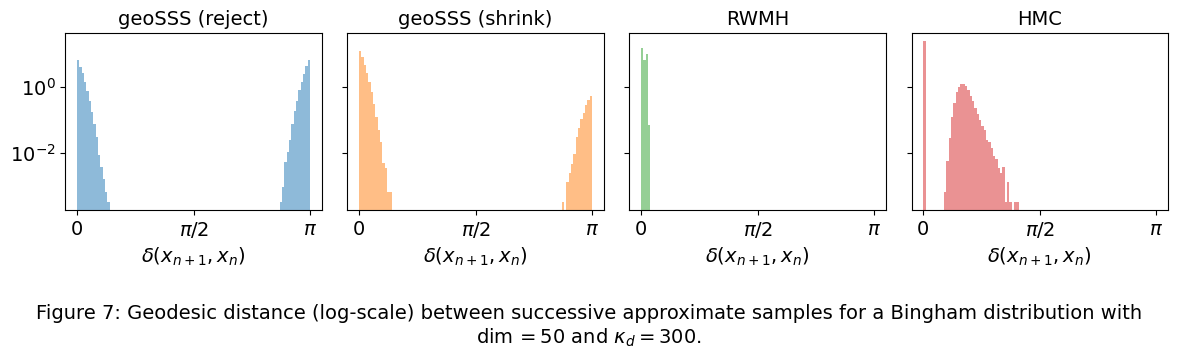

In [9]:
fig, axes = plt.subplots(
    1, len(methods), figsize=(len(methods) * 3, 3), sharex=True, sharey=True
)
bins = 100
for ax, method in zip(axes, methods):
    ax.set_title(algos[method], fontsize=fs)
    # distance between successive samples
    x = samples_d50[method]
    dist = gs.distance(x[:-1], x[1:])
    print(
        "average great circle distance of successive samples: "
        f"{np.mean(dist):.2f} ({method})"
    )
    bins = ax.hist(
        dist,
        bins=bins,
        density=True,
        alpha=0.5,
        color=colors[methods.index(method)],
        histtype="stepfilled",
    )[1]
    ax.set_xlabel(r"$\delta(x_{n+1}, x_n)$", fontsize=fs)
    ax.set_xticks(np.linspace(0.0, np.pi, 3))
    ax.set_xticklabels(["0", r"$\pi/2$", r"$\pi$"])
    ax.set_yscale("log")
fig.text(
    0.5,
    -0.2,
    r"Figure 7: Geodesic distance (log-scale) between successive approximate samples for a Bingham distribution with $\dim=50$ and $\kappa_d=300$.",
    ha="center",
    va="bottom",
    fontsize=fs,
    wrap=True,
)
fig.tight_layout()
